In [1]:
import os
import sys
import time
import re
import numpy as np
from numpy import *
from pylab import *
from scipy import *
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


import pystan

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [3]:
%pylab inline
#%matplotlib notebook
plt.style.use('seaborn-talk');

Populating the interactive namespace from numpy and matplotlib


/home/meysam/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt', 'fft', 'arccos', 'test', 'show_config', 'log', '__version__', 'linalg', 'log2', 'arcsin', 'log10', 'power', 'arctanh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
Mainpath = '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/'

# Generate Synthetic Data

In [5]:
a = 5
b = 5
c=5
sigma=1
random.seed(11442)
noise =sigma * randn() 

In [6]:
nt = 100
t = linspace(-5, 5, nt)
y = a*(t**2)+b*t+c
y_model = y+sigma*randn(y.size)

In [7]:
nt_outl=2
t_outl=linspace(5, 6, nt_outl)
y_outl=35*t_outl

In [8]:
nt_obs=nt+nt_outl
t_obs=concatenate((t,t_outl), axis=0)
yobs=concatenate((y_model,y_outl), axis=0)

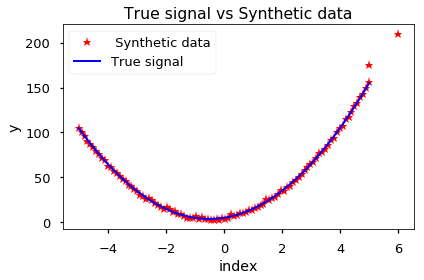

In [9]:
figure(figsize=(6, 4))
plot(t_obs,yobs,'r*', label=' Synthetic data' )
plot(t,y, color='b', linewidth=2.0, label='True signal')
xlabel("index")
ylabel("y")
title('True signal vs Synthetic data')
legend()
tight_layout()
show() 



# Save Data to run Stan

In [10]:
! mkdir -p  data_input_files

In [11]:
data_input= {'nt': nt_obs, 't': t_obs, 'yobs': yobs}


nd=[]
npz = {'nd': nd}
npz.update(data_input)


np.savez(Mainpath+'/data_input_files/'+'data_input.R.npz', **npz)
np.savez(Mainpath+'/data_input_files/'+'data_input.npz', **npz)
pystan.stan_rdump(data_input, Mainpath+'/data_input_files/'+'data_input.R')


In [12]:
data_input = dict(load(Mainpath+'/data_input_files/'+'data_input.R.npz'))

In [13]:
#data = pystan.read_rdump('data.R')
# savez('data_input.npz', **npz)
# savez('data_input.R.npz', **npz)
# pystan.stan_rdump(data_input, 'data_input.R')

## Hypo1

In [14]:
Hypo1 = open('Hypo1.stan').read()    
print(Hypo1)

data {
  int nt;
  real t[nt];
  real yobs[nt];
}

parameters {
  real p2;
  real p1;
  real p0;
  real<lower=0> sigma;
}


model {

  real y[nt];
  p2~normal(5, 0.05);
  p1~normal(5, 0.05);
  p0~normal(5, 0.05);

  for (i in 1:nt) {
    y[i] = p2*pow(t[i],2)+p1*pow(t[i],1)+p0*pow(t[i],0) ;
  }
  
  yobs ~ normal(y, sigma);

}

generated quantities {
  vector[nt] log_lik;
  real y[nt];

  for (i in 1:nt) {
    y[i] = p2*pow(t[i],2)+p1*pow(t[i],1)+p0*pow(t[i],0) ;
  }
  for (i in 1:nt){
  log_lik[i] = normal_lpdf(yobs[i]| y[i], sigma);
  }
}


In [15]:
tic=time.time()
model1 =pystan.StanModel(model_code=Hypo1) 
print(time.time()- tic, 'second is required to run')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d024f445091021e4c896ce5eaf05e18 NOW.


42.280595541000366 second is required to run


In [16]:
fit1 = model1.sampling(data=data_input, algorithm='NUTS', iter=2000,  warmup=500, 
                      control=dict(adapt_delta=0.85), chains=1, n_jobs=-1, verbose=True, refresh=500) 

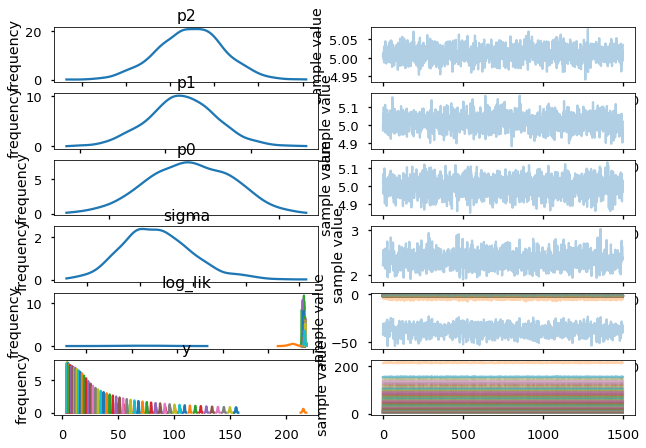

Inference for Stan model: anon_model_5d024f445091021e4c896ce5eaf05e18.
1 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p2             5.01  4.8e-4   0.02   4.97    5.0   5.01   5.02   5.05   1500    1.0
p1             5.02  1.0e-3   0.04   4.94   4.99   5.02   5.05    5.1   1500    1.0
p0              5.0  1.3e-3   0.05    4.9   4.96   4.99   5.03   5.09   1500    1.0
sigma          2.33  4.3e-3   0.17   2.04   2.22   2.32   2.43   2.71   1500    1.0
log_lik[0]    -1.79  2.4e-3   0.08  -1.97  -1.84  -1.79  -1.74  -1.66   1139    1.0
log_lik[1]     -1.8  2.4e-3   0.08  -1.98  -1.85   -1.8  -1.74  -1.66   1190    1.0
log_lik[2]    -1.81  2.3e-3   0.08  -1.99  -1.86   -1.8  -1.75  -1.66   1343    1.0
log_lik[3]    -1.95  3.2e-3   0.12  -2.23  -2.02  -1.94  -1.86  -1.75   1500    1.0
log_lik[4]    -1.79  2.1e-3   0.08  -1.96  -1.84  -1.79 

In [17]:
fit1.plot()
show()
print (fit1)

In [18]:
traces=fit1.extract(permuted=True)

In [19]:
p2_l,p2_h =percentile(traces['p2'], [2.5,97.5], axis=0)
p1_l,p1_h =percentile(traces['p1'], [2.5,97.5], axis=0)
p0_l,p0_h =percentile(traces['p0'], [2.5,97.5], axis=0)

In [20]:
p0_est=traces['p0'].mean()
p1_est=traces['p1'].mean()
p2_est=traces['p2'].mean()

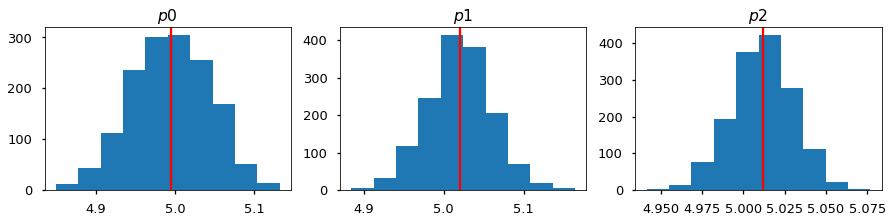

In [21]:
figure(figsize=(15,3))
subplot(1,3,1);
hist(traces['p0'][:], bins=10);
axvline(p0_est, color='r')
title(r'$p0$')
subplot(1,3,2);
hist(traces['p1'][:], bins=10);
axvline(p1_est, color='r')
title(r'$p1$')
subplot(1,3,3);
hist(traces['p2'][:], bins=10);
axvline(p2_est, color='r')
title(r'$p2$')
show()

In [22]:
y_fit_l = p2_l*pow(t_obs,2)+p1_l*pow(t_obs,1)+p0_l*pow(t_obs,0)
y_fit_h = p2_h*pow(t_obs,2)+p1_h*pow(t_obs,1)+p0_h*pow(t_obs,0)

y_fit =p2_est*pow(t_obs,2)+ p1_est*pow(t_obs,1)+p0_est*pow(t_obs,0)

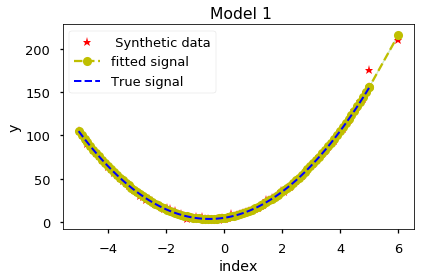

In [23]:
figure(figsize=(6, 4))

plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'y--o', label='fitted signal' )
plot(t, y, 'b--', linewidth=2.0, label='True signal')
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title(' Model 1')
legend()
tight_layout()
show() 

## Hypo3

In [24]:
Hypo3 = open('Hypo3.stan').read()    
print(Hypo3)

data {
  int nt;
  real t[nt];
  real yobs[nt];
}

parameters {
  real p2;
  real p1;
  real p0;
  real<lower=0> sigma;
}


model {

  real y[nt];
  p2~normal(-15, 0.05);
  p1~normal(-15, 0.05);
  p0~normal(-15, 0.05);

  for (i in 1:nt) {
    y[i] = p2*pow(t[i],2)+p1*pow(t[i],1)+p0*pow(t[i],0) ;
  }
  
  yobs ~ normal(y, sigma);

}

generated quantities {
  vector[nt] log_lik;
  real y[nt];

  for (i in 1:nt) {
    y[i] = p2*pow(t[i],2)+p1*pow(t[i],1)+p0*pow(t[i],0) ;
  }
  for (i in 1:nt){
  log_lik[i] = normal_lpdf(yobs[i]| y[i], sigma);
  }
}


In [25]:
tic=time.time()
model3 =pystan.StanModel(model_code=Hypo3) 
print(time.time()- tic, 'second is required to run')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_165a7b9f2e7cc2045e5cf63291b2286d NOW.


42.613664388656616 second is required to run


In [26]:
fit3 = model3.sampling(data=data_input, algorithm='NUTS', iter=2000,  warmup=500, 
                      control=dict(adapt_delta=0.85), chains=1, n_jobs=-1, verbose=True, refresh=500) 

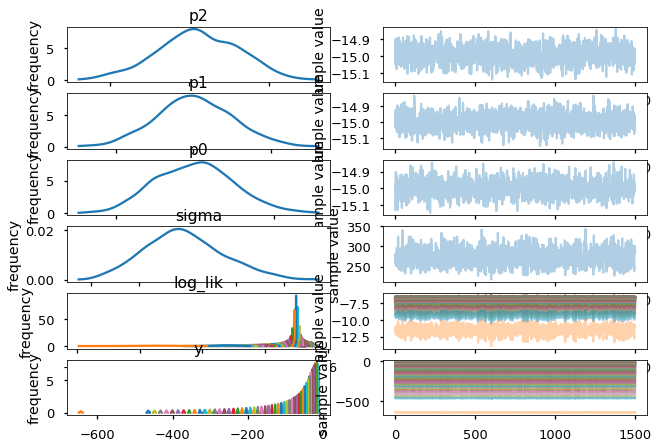

Inference for Stan model: anon_model_165a7b9f2e7cc2045e5cf63291b2286d.
1 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p2           -14.99  1.3e-3   0.05 -15.09 -15.02 -14.99 -14.95 -14.89   1500    1.0
p1            -15.0  1.4e-3   0.05 -15.09 -15.03  -15.0 -14.97  -14.9   1275    1.0
p0            -15.0  1.3e-3   0.05 -15.09 -15.04  -15.0 -14.97  -14.9   1500    1.0
sigma        273.25    0.52  20.17 236.46 259.09 271.88 285.99  316.1   1500    1.0
log_lik[0]    -7.72  2.7e-3    0.1  -7.96  -7.79  -7.72  -7.65  -7.55   1500    1.0
log_lik[1]    -7.62  2.3e-3   0.09  -7.83  -7.68  -7.62  -7.56  -7.48   1500    1.0
log_lik[2]    -7.53  1.9e-3   0.07   -7.7  -7.58  -7.52  -7.48  -7.41   1500    1.0
log_lik[3]    -7.44  1.6e-3   0.06  -7.58  -7.47  -7.43  -7.39  -7.34   1500    1.0
log_lik[4]    -7.36  1.3e-3   0.05  -7.48  -7.39  -7.35 

In [27]:
fit3.plot()
show()
print (fit3)

In [28]:
traces=fit3.extract(permuted=True)

In [29]:
p2_l,p2_h =percentile(traces['p2'], [2.5,97.5], axis=0)
p1_l,p1_h =percentile(traces['p1'], [2.5,97.5], axis=0)
p0_l,p0_h =percentile(traces['p0'], [2.5,97.5], axis=0)

In [30]:
p0_est=traces['p0'].mean()
p1_est=traces['p1'].mean()
p2_est=traces['p2'].mean()

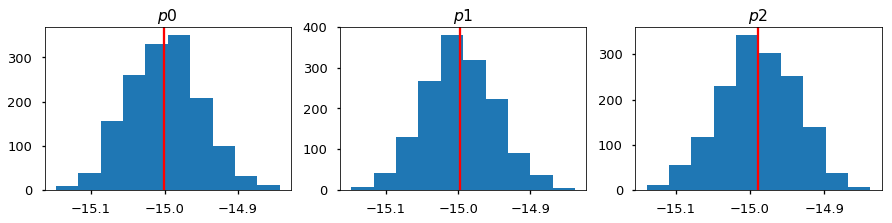

In [31]:
figure(figsize=(15,3))
subplot(1,3,1);
hist(traces['p0'][:], bins=10);
axvline(p0_est, color='r')
title(r'$p0$')
subplot(1,3,2);
hist(traces['p1'][:], bins=10);
axvline(p1_est, color='r')
title(r'$p1$')
subplot(1,3,3);
hist(traces['p2'][:], bins=10);
axvline(p2_est, color='r')
title(r'$p2$')
show()

In [32]:
y_fit_l = p2_l*pow(t_obs,2)+p1_l*pow(t_obs,1)+p0_l*pow(t_obs,0)
y_fit_h = p2_h*pow(t_obs,2)+p1_h*pow(t_obs,1)+p0_h*pow(t_obs,0)

y_fit =p2_est*pow(t_obs,2)+ p1_est*pow(t_obs,1)+p0_est*pow(t_obs,0)

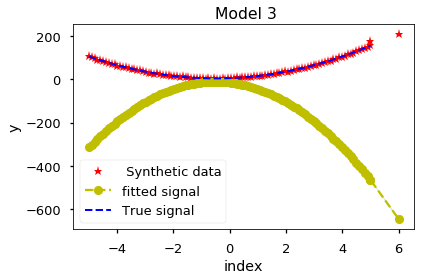

In [33]:
figure(figsize=(6, 4))

plot(t_obs, yobs,'r*', label=' Synthetic data' )
plot(t_obs, y_fit,'y--o', label='fitted signal' )
plot(t, y, 'b--', linewidth=2.0, label='True signal')
fill_between(t_obs, y_fit_l, y_fit_h, alpha=0.2, facecolor='g', edgecolor='none')

xlabel("index")
ylabel("y")
title(' Model 3')
legend()
tight_layout()
show() 

# Measuring information criteria and LOO

Hypo1(strongly correct hypo): p~normal(p_true, 0.05)

Hypo2(weakly  correct hypo):  p~normal(p_true, 2)

Hypo3(strongly wrong hypo):   p~normal(p_wrong, 0.05)

Hypo4(weakly  wrong hypo):    p~normal(p_wrong, 2)


In [34]:
!ls

checking_converged_advi.py  ComputePSIS.py    parse_csv.py
checking_converged_hmc.py   data_input_files  PolynomialHyposComparision.ipynb
checking_converged_opt.py   Hypo1.stan	      RunCV.sh
cmdstan			    Hypo2.stan	      RunIC.sh
ComputeICcsv.py		    Hypo3.stan	      RunPyStan4IC.py
ComputeIC.py		    Hypo4.stan
ComputePSIScsv.py	    ICbug.ipynb


In [25]:
tic=time.time()
!./RunIC.sh 
print('total running time is: ', time.time()- tic, 'second')

1  /  4  :  Hypo1
...Running Pystan1 started...
..............................................
creating model ...
creating model done.
loading data ...
...sampling hmc...

Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 [ 25%]  (Warmup)
Iteration:  501 / 2000 [ 25%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Sampling)
Iteration: 1500 / 2000 [ 75%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.074597 seconds (Warm-up)
               0.196709 seconds (Sampling)
               0.271306 seconds (Total)

..saving...
..............................................
...Running Pystan2 started...
..............................................
creating model ...
creating model done.
loading data ...
...sampling hmc...

Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog st


{'loo': -244.00338057260004, 'loos': array([ -1.79824053,  -1.80663037,  -1.81232083,  -1.96267017,
        -1.79870645,  -1.78244975,  -1.78143936,  -1.77986878,
        -1.78450217,  -1.89401855,  -2.00815561,  -1.78301256,
        -1.92860127,  -1.77673681,  -1.77358613,  -1.78670955,
        -1.77287386,  -1.85345056,  -1.81963283,  -1.77344971,
        -1.79406597,  -2.13527013,  -1.84372377,  -2.08763555,
        -2.08400293,  -1.90089526,  -1.7719522 ,  -1.76980644,
        -1.77177145,  -1.95724041,  -2.28946371,  -2.17252059,
        -1.78889932,  -2.15463409,  -1.7836373 ,  -1.84344918,
        -1.77485805,  -2.3222648 ,  -1.99632576,  -1.8470203 ,
        -2.0355149 ,  -1.91540917,  -2.07300583,  -1.8084583 ,
        -1.7682033 ,  -1.83754723,  -1.89825058,  -1.77332492,
        -1.92437664,  -1.78077414,  -1.87588091,  -1.83764286,
        -2.54654411,  -1.78024623,  -1.77504938,  -1.7944454 ,
        -1.76740639,  -1.76664645,  -1.77694981,  -1.77662578,
        -1.795660

Writing complete
...Computing PSIS terminated.
..................................................................................................
2  /  4  :  Hypo2
...Running Pystan1 started...
..............................................
creating model ...
creating model done.
loading data ...
...sampling hmc...

Gradient evaluation took 2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 [ 25%]  (Warmup)
Iteration:  501 / 2000 [ 25%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Sampling)
Iteration: 1500 / 2000 [ 75%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.100052 seconds (Warm-up)
               0.231201 seconds (Sampling)
               0.331253 seconds (Total)

..saving...
..............................................
...Running Pystan2 started...
..............................................
creating mod


{'loo': -244.92927539939592, 'loos': array([ -1.81912168,  -1.82310354,  -1.82528913,  -1.95840719,
        -1.81042147,  -1.80376231,  -1.80251218,  -1.79694877,
        -1.79516278,  -1.94548127,  -1.97907451,  -1.80832564,
        -1.90410424,  -1.79832245,  -1.79108116,  -1.78870621,
        -1.79183904,  -1.83478113,  -1.86276835,  -1.7822206 ,
        -1.82979546,  -2.07402806,  -1.82407861,  -2.02974226,
        -2.17853305,  -1.9681556 ,  -1.79737114,  -1.78051726,
        -1.77987915,  -1.91427291,  -2.41426986,  -2.28478365,
        -1.78588547,  -2.26587113,  -1.78350795,  -1.90253307,
        -1.78058368,  -2.23909609,  -1.94911091,  -1.82663002,
        -2.13108865,  -1.88207912,  -2.17310451,  -1.79992581,
        -1.7814001 ,  -1.82164466,  -1.87063965,  -1.78145428,
        -1.89391665,  -1.78454211,  -1.85473399,  -1.82451895,
        -2.68067413,  -1.78481838,  -1.80379777,  -1.83098613,
        -1.78113791,  -1.78165028,  -1.80418158,  -1.78351686,
        -1.796435

Writing complete
...Computing PSIS terminated.
..................................................................................................
3  /  4  :  Hypo3
...Running Pystan1 started...
..............................................
creating model ...
creating model done.
loading data ...
...sampling hmc...

Gradient evaluation took 2.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 [ 25%]  (Warmup)
Iteration:  501 / 2000 [ 25%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Sampling)
Iteration: 1500 / 2000 [ 75%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.066997 seconds (Warm-up)
               0.270523 seconds (Sampling)
               0.33752 seconds (Total)

..saving...
..............................................
...Running Pystan2 started...
..............................................
creating m


{'loo': -716.65789677246028, 'loos': array([ -7.72922333,  -7.62669296,  -7.53137276,  -7.43873811,
        -7.36127629,  -7.28691805,  -7.21598046,  -7.14969493,
        -7.08811346,  -7.03712507,  -6.97586848,  -6.9348064 ,
        -6.88635993,  -6.85103499,  -6.81434343,  -6.78011979,
        -6.75134495,  -6.72180916,  -6.70100116,  -6.67706015,
        -6.65862838,  -6.63667151,  -6.62298052,  -6.60783769,
        -6.60087396,  -6.58914928,  -6.57855172,  -6.5700753 ,
        -6.56306158,  -6.55607905,  -6.55413281,  -6.54947554,
        -6.54409703,  -6.54263771,  -6.5388099 ,  -6.53747648,
        -6.53536193,  -6.53339815,  -6.532773  ,  -6.53225095,
        -6.53241151,  -6.53125414,  -6.53168141,  -6.53094363,
        -6.53096386,  -6.53081741,  -6.53083139,  -6.53117913,
        -6.53121732,  -6.53180737,  -6.53215312,  -6.5329095 ,
        -6.53521598,  -6.53520055,  -6.53703901,  -6.53910748,
        -6.54114223,  -6.54406695,  -6.54785663,  -6.55155946,
        -6.556323

Writing complete
...Computing PSIS terminated.
..................................................................................................
4  /  4  :  Hypo4
...Running Pystan1 started...
..............................................
creating model ...
creating model done.
loading data ...
...sampling hmc...

Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  500 / 2000 [ 25%]  (Warmup)
Iteration:  501 / 2000 [ 25%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Sampling)
Iteration: 1500 / 2000 [ 75%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.111498 seconds (Warm-up)
               0.259589 seconds (Sampling)
               0.371087 seconds (Total)

..saving...
..............................................
...Running Pystan2 started...
..............................................
creating 


{'loo': -246.95200394858261, 'loos': array([ -1.86895355,  -1.87865516,  -1.88055371,  -2.0582321 ,
        -1.8477624 ,  -1.81349242,  -1.81067252,  -1.80978842,
        -1.81401414,  -1.92105805,  -2.01700649,  -1.81427006,
        -1.92509232,  -1.80933156,  -1.80406969,  -1.80089282,
        -1.8079912 ,  -1.83645442,  -1.89230185,  -1.79793586,
        -1.86396796,  -2.02542432,  -1.81575717,  -1.97558198,
        -2.27528332,  -2.04968034,  -1.84012343,  -1.80727916,
        -1.80436605,  -1.8619607 ,  -2.58653312,  -2.4512581 ,
        -1.79609211,  -2.444965  ,  -1.79919005,  -2.01892462,
        -1.80776808,  -2.07793659,  -1.86566346,  -1.80024664,
        -2.32724249,  -1.82297163,  -2.38649063,  -1.79639589,
        -1.82813677,  -1.79787316,  -1.81444441,  -1.81668249,
        -1.82448777,  -1.80795194,  -1.80678666,  -1.79797476,
        -3.00906027,  -1.80793304,  -1.89696169,  -1.9474576 ,
        -1.83076372,  -1.83522873,  -1.89741419,  -1.80857126,
        -1.797432

Writing complete
...Computing PSIS terminated.
..................................................................................................
Jobe done!
total running time is:  22.104893445968628 second


# Plot  functions

Lets see what we have in the current dir!

In [26]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

def bestmodel_barplot(y, y_err):
    bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
    bar(argmin(y), y[argmin(y)], yerr=y_err[argmin(y)], color='r',  error_kw=error_kw_red, label="Best Model")
    xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
    return

In [27]:
def scatter_plot(y): 
    from matplotlib import cm
    #colors = cm.seismic(y / float(max(y)))
    plot = plt.scatter(r_[:y.shape[0]]+1, y, c = y, cmap = 'seismic', lw=4)
    plt.colorbar(plot)
    #plt.stem(r_[:y.shape[0]]+1, y, color = colors,linewidth=2, basefmt=" ")
    return 

In [28]:
def k_count(y,y_thr): 
    k=((y > y_thr).sum()/y.size)*100   
    return k

In [29]:
import re
import glob
from operator import itemgetter

cwd = os.getcwd()
os.chdir(cwd)

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Plot information criteria

In [30]:
allStanFiles = sorted(glob.glob(cwd + "/*.stan"), key=numericalSort)

allStanFiles

['/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.stan',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.stan',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.stan',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.stan']

In [31]:
Models= [x.rsplit('/')[-1].rsplit('.stan')[-2] for x in allStanFiles]

print(Models)

['Hypo1', 'Hypo2', 'Hypo3', 'Hypo4']


In [32]:
allReport_textFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

allReport_textFiles

['/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.stan_report_Ic.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.stan_report_psis.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.stan_report_Ic.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.stan_report_psis.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.stan_report_Ic.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.stan_report_psis.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.stan_report_Ic.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.stan_report_psis.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/output_CV_Hypo1.txt',
 '/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/outp

In [33]:
all_IcFiles= [x.rsplit('/')[-1] for x in allReport_textFiles if 'Ic' in x]

all_IcFiles

['Hypo1.stan_report_Ic.txt',
 'Hypo2.stan_report_Ic.txt',
 'Hypo3.stan_report_Ic.txt',
 'Hypo4.stan_report_Ic.txt']

In [34]:
!cat Hypo1.stan_report_Ic.txt

maxlike    , -1.6	, 0.0
p_waic     , 28.7	, 1.9
elpd_waic  , -249.7	, 1.3
waic       , 499.4	, 2.5
aicc       , 9.3	, 0.0
aic        , 9.1	, 0.0
dic        , 4.5	, 7.2
bic        , 17.0	, 0.0


In [35]:
!cat Hypo3.stan_report_Ic.txt

maxlike    , -6.3	, 0.0
p_waic     , 1.3	, 0.0
elpd_waic  , -716.6	, 0.0
waic       , 1433.3	, 0.1
aicc       , 18.9	, 0.0
aic        , 18.6	, 0.0
dic        , 14.0	, 1.6
bic        , 26.5	, 0.0


In [36]:
IC_elements = []
with open(all_IcFiles[0], 'r') as fd:
    for line in fd.readlines():
        IC_elements.append(line.strip().split()[0])
        
IC_elements

['maxlike', 'p_waic', 'elpd_waic', 'waic', 'aicc', 'aic', 'dic', 'bic']

In [37]:
maxlike_idx=IC_elements.index('maxlike')
p_waic_idx=IC_elements.index('p_waic')
elpd_waic_idx=IC_elements.index('elpd_waic')
waic_idx=IC_elements.index('waic')
dic_idx=IC_elements.index('dic')
aicc_idx=IC_elements.index('aicc')
aic_idx=IC_elements.index('aic')
bic_idx=IC_elements.index('bic')

In [38]:
IC=[loadtxt(x, delimiter=',', usecols=(1) ).T for x in all_IcFiles]
IC_err=[loadtxt(x, delimiter=',', usecols=(2) ).T for x in all_IcFiles]

IC=asarray(IC)
IC_err=asarray(IC_err)

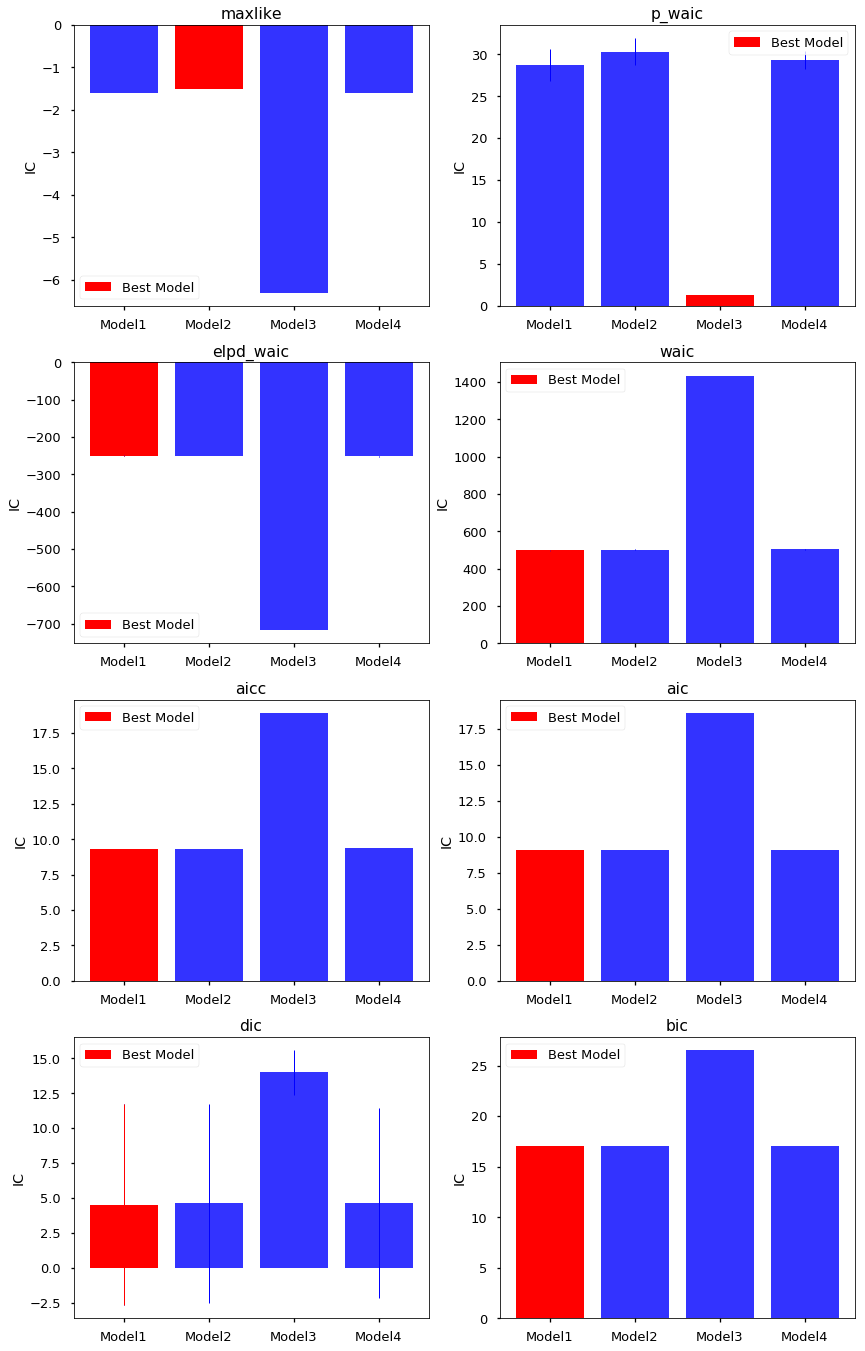

In [39]:
figure(figsize=(14, 30))

error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

for i in range(len(IC_elements)):
     subplot(len(IC_elements)//2+1, 2, i + 1)  
     y=[IC[j][i]  for j in range(0,len(IC))]
     y_err=[IC_err[j][i]  for j in range(0,len(IC))]

     if i in (elpd_waic_idx, maxlike_idx):
         bar(r_[:len(IC)], y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
         barlist= bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red, label="Best Model")
     else:
         bar(r_[:len(IC)], y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
         barlist= bar(argmin(y), y[argmin(y)], yerr=y_err[argmin(y)], color='r',  error_kw=error_kw_red, label="Best Model")
     #xticks(r_[:len(IC)], [Models[j]  for j in range(0,len(IC))], rotation=70);
     xticks(r_[:len(IC)], ['Model1','Model2','Model3','Model4' ], rotation=0);
     ylabel('IC')
     title(IC_elements[i])
     legend()

show() 

In [50]:
elpd_waic=[IC[j][elpd_waic_idx]  for j in range(0,len(IC))]
p_waic=[IC[j][p_waic_idx]  for j in range(0,len(IC))]
waic=[IC[j][waic_idx]  for j in range(0,len(IC))]
dic=[IC[j][dic_idx]  for j in range(0,len(IC))]
aicc=[IC[j][aicc_idx]  for j in range(0,len(IC))]
aic=[IC[j][aic_idx]  for j in range(0,len(IC))]
bic=[IC[j][bic_idx]  for j in range(0,len(IC))]

In [51]:
elpd_waic_err=[IC_err[j][elpd_waic_idx]  for j in range(0,len(IC_err))]
p_err=[IC_err[j][p_waic_idx]  for j in range(0,len(IC_err))]
waic_err=[IC_err[j][waic_idx]  for j in range(0,len(IC_err))]
dic_err=[IC_err[j][dic_idx]  for j in range(0,len(IC_err))]
aicc_err=[IC_err[j][aicc_idx]  for j in range(0,len(IC_err))]
aic_err=[IC_err[j][aic_idx]  for j in range(0,len(IC_err))]
bic_err=[IC_err[j][bic_idx]  for j in range(0,len(IC_err))]

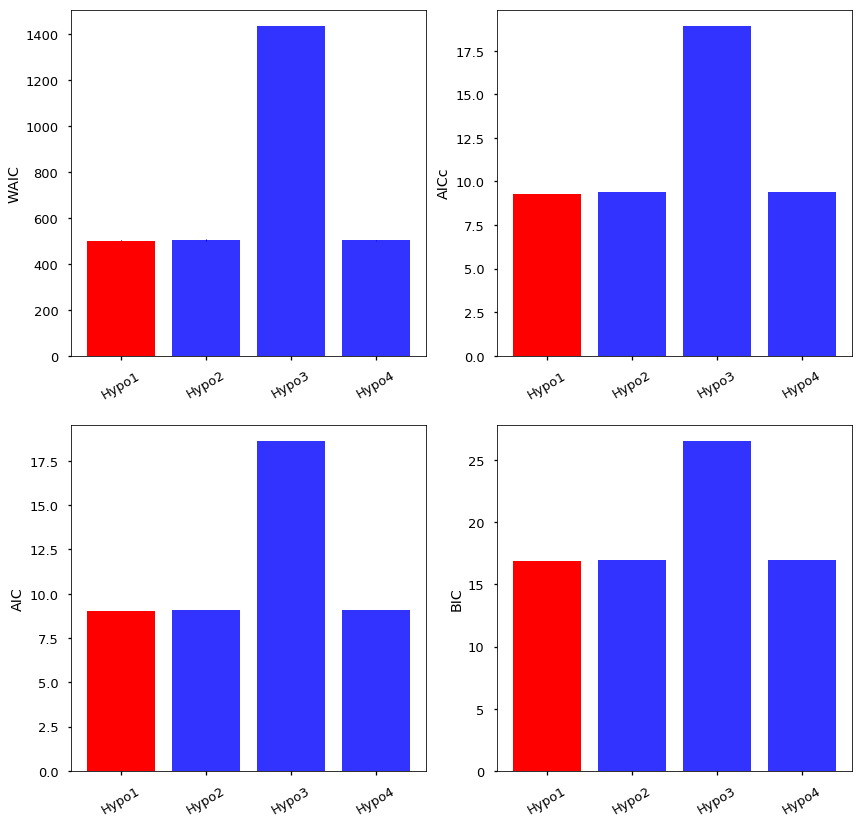

In [52]:
figure(figsize=(14, 14))

subplot(221)
y = waic
y_err = waic_err
bestmodel_barplot(y, y_err)
ylabel("WAIC")

subplot(222)
y = aicc
y_err = aicc_err
bestmodel_barplot(y, y_err)
ylabel("AICc")

subplot(223)
y = aic
y_err = aic_err
bestmodel_barplot(y, y_err)
ylabel("AIC")

subplot(224)
y = bic
y_err = bic_err
bestmodel_barplot(y, y_err)
ylabel("BIC")

show()

# Which One?!

In [53]:
Best_model=[]

if "waic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,waic_idx]), key=itemgetter(1))[0]+1)
if "dic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,dic_idx]), key=itemgetter(1))[0]+1)    
if "aicc" in IC_elements:
    Best_model.append(min(enumerate(IC[:,aicc_idx]), key=itemgetter(1))[0]+1)
if "aic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,aic_idx]), key=itemgetter(1))[0]+1)
if "bic" in IC_elements:
    Best_model.append(min(enumerate(IC[:,bic_idx]), key=itemgetter(1))[0]+1)

In [54]:
print('Best model is model: ', Best_model)

Best model is model:  [1, 1, 1, 1, 1]


Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value.

# PSIS

# Measuring PSIS-LOO

In [55]:
Chains= ['chain 1', 'chain 2', 'chain 3','chain 4' ]

PSIS_elements=['loo', 'loos', 'ks']

In [56]:
allReport_txtFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_PsisFiles= [x.rsplit('/')[-1] for x in allReport_txtFiles if  'psis' in x]

all_PsisFiles

['Hypo1.stan_report_psis.txt',
 'Hypo2.stan_report_psis.txt',
 'Hypo3.stan_report_psis.txt',
 'Hypo4.stan_report_psis.txt']

In [57]:
PSISs=[pystan.read_rdump(psis_file) for psis_file in all_PsisFiles]
PSISs=asarray(PSISs)

In [58]:
for i in range(len(PSISs)):
    print ('for model_%d.stan:' % (i+1, ))
    for key, val in PSISs[i].items():
        print(key, val.shape)

for model_1.stan:
loo (4,)
loos (4, 102)
ks (4, 102)
for model_2.stan:
loo (4,)
loos (4, 102)
ks (4, 102)
for model_3.stan:
loo (4,)
loos (4, 102)
ks (4, 102)
for model_4.stan:
loo (4,)
loos (4, 102)
ks (4, 102)


In [59]:
PSISs_dict = {}
for i in range(len(all_PsisFiles)):
    model = 'model' + str(i)
    PSISs_dict[model] = pystan.read_rdump(all_PsisFiles[i])

In [60]:
PSISs[0]['loo'], PSISs_dict['model1']['loo']

(array([-244.54118738, -244.3404597 , -244.94869268, -243.8610182 ]),
 array([-245.88324889, -241.81612571, -243.83853027, -242.78247329]))

Plot Loo, Loos

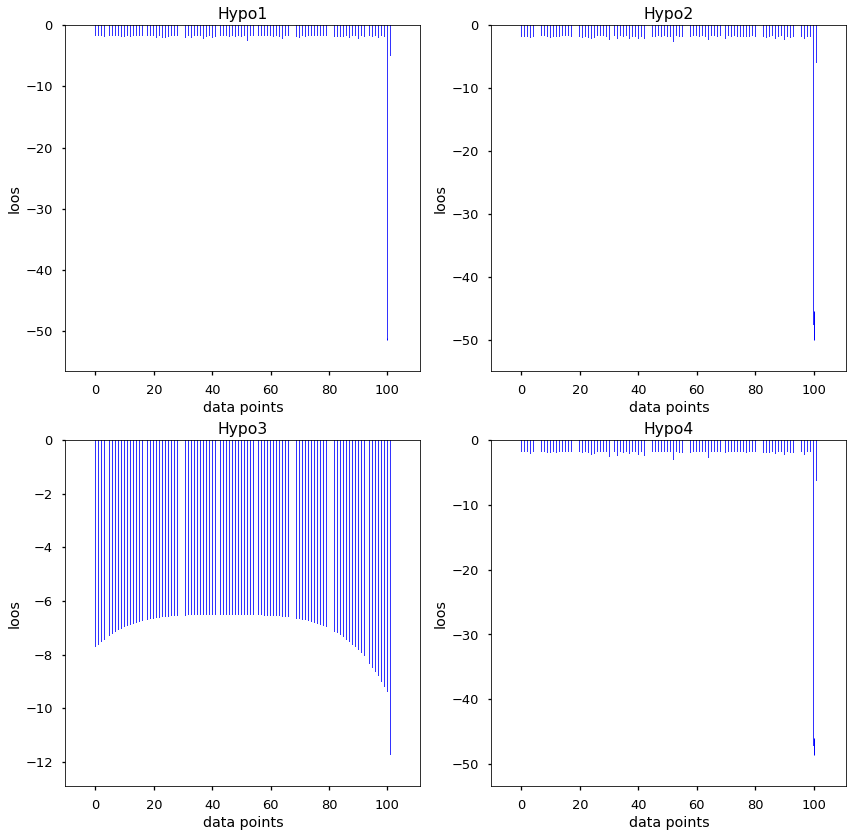

In [61]:
figure(figsize=(14, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     Loos=PSISs[i]['loos']
     Loos_mean=mean(Loos, axis=0)
     Loos_err=var(Loos, axis=0)
     bar(r_[:len(Loos_mean)], Loos_mean, width=0.3, color='b', alpha=0.8); 
     errorbar(r_[:len(Loos_mean)], y=Loos_mean, yerr=Loos_err, fmt='none', ecolor='b', capsize=4, elinewidth=1);  
     plt.margins(0.1, 0.1)
     ylabel('loos')
     xlabel('data points')
     title(Models[i])
    
show() 

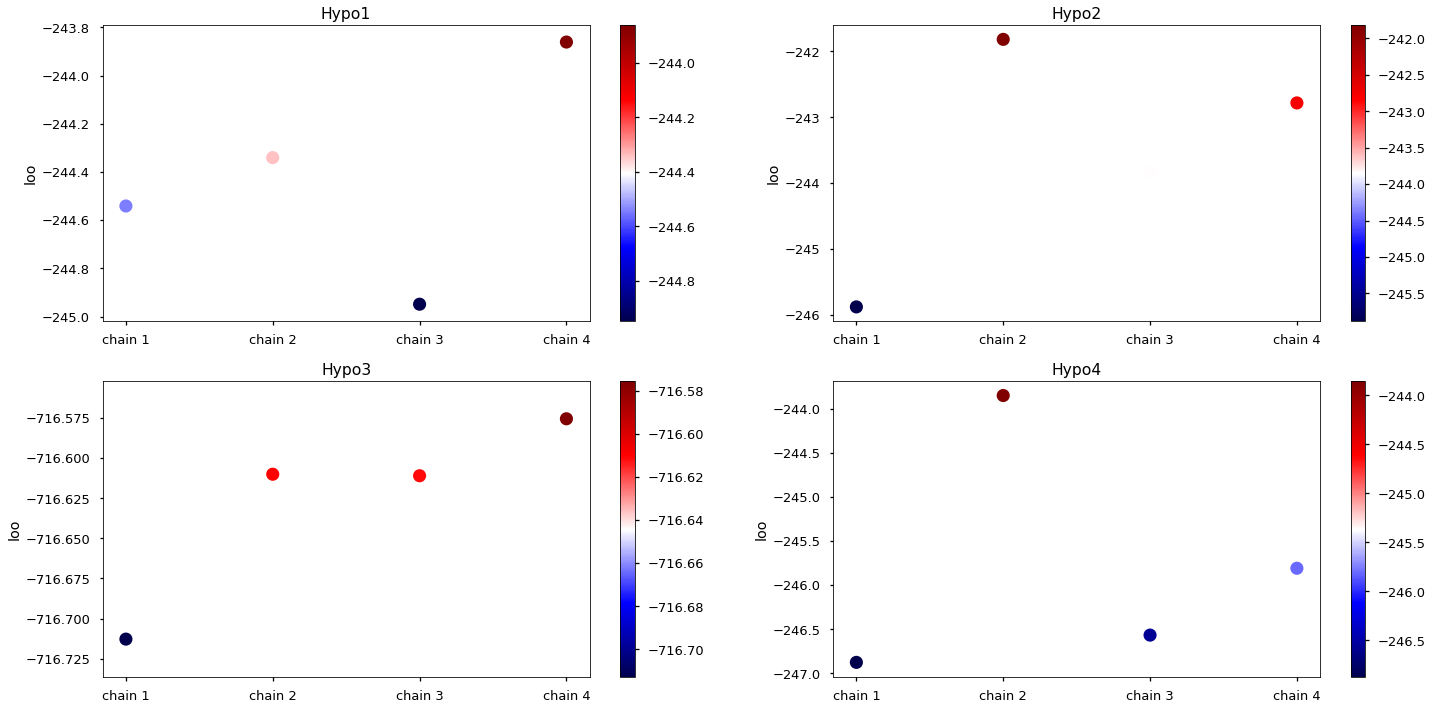

In [62]:
figure(figsize=(24,12))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['loo']
     scatter_plot(y)
     xticks(r_[:len(Chains)]+1, [Chains[i] for i in range(0,len(Chains))]);
     ylabel('loo')
     title(Models[i])
       
show() 

Compare elpd_waic and Loo

In [63]:
Loo=[]
Loo_err=[]
for i in range(len(all_PsisFiles)):
    Loo.append(PSISs[i]['loo'].mean())
    Loo_err.append(PSISs[i]['loo'].std())

In [64]:
print ('elpd_waic =',  asarray(elpd_waic))
print()
print ('PSIS-LOO =',  asarray(Loo)) 
print()
print ('the difference between elpd_waic and PSIS-LOO =', subtract(asarray(Loo) , asarray(elpd_waic)) )


elpd_waic = [-250.5 -251.5 -716.6 -251.5]

PSIS-LOO = [-244.42283949 -243.58009454 -716.62731933 -245.77570563]

the difference between elpd_waic and PSIS-LOO = [ 6.07716051  7.91990546 -0.02731933  5.72429437]


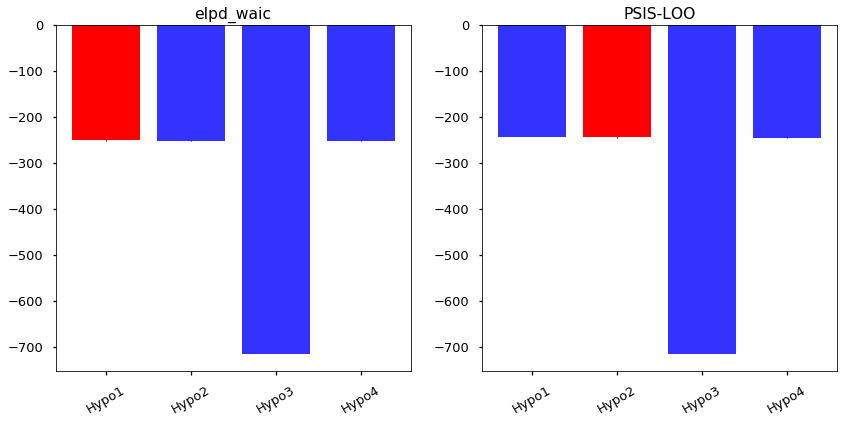

In [65]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

figure(figsize=(14, 14))

subplot(221)
y = elpd_waic
y_err = elpd_waic_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))],rotation=30);
title("elpd_waic")

subplot(222)
y = Loo
y_err = Loo_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
title("PSIS-LOO")
show()

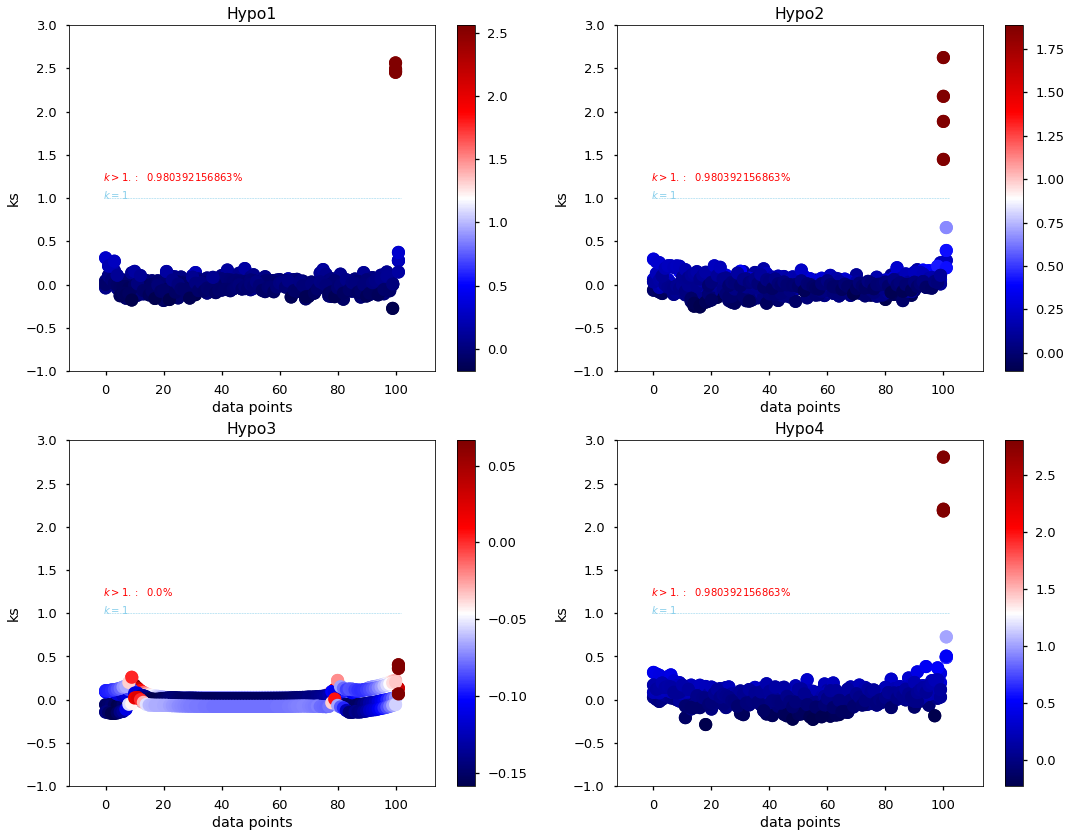

In [66]:
figure(figsize=(18, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['ks']
     k_=k_count(y,1.)
     for j in range(len(Chains)):
            yj=y[j,:]
            plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
            yallj=yj.flatten()
            plotallj = plt.scatter(r_[:yallj.shape[0]] , yallj, c = yallj, cmap = 'seismic', lw=4)
     plt.colorbar(plotallj)       
     plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
     text(-1,0.99, "$k=1.$", size=10, color = 'skyblue')
     text(-1, 1.2,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
     ylim([-1,3.])
     plt.margins(0.11, 0.1)
     #norm_colorbar(y.flatten())
     ylabel('ks')
     xlabel('data points')
     title(Models[i])

show() 

# Running automatic CV ADVI

In [67]:
tic=time.time()
!./RunCV.sh 
print('total running time is: ', time.time()- tic, 'second')

/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos
1  /  4  :  Hypo1
......................................................
creating models ...

--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.stan --o=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.hpp
Model name=Hypo1_model
Input file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.stan
Output file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo1.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_mat


{'loo': -245.75588869959088, 'loos': array([ -1.80713387,  -1.81860305,  -1.82559041,  -1.99540031,
        -1.80793905,  -1.7815184 ,  -1.78004529,  -1.78076446,
        -1.78898245,  -1.87504422,  -2.03486127,  -1.77825418,
        -1.94788807,  -1.77377299,  -1.77223724,  -1.79095021,
        -1.77094704,  -1.86352288,  -1.81115984,  -1.77428222,
        -1.78834402,  -2.1530767 ,  -1.85021647,  -2.10180378,
        -2.07066528,  -1.89227895,  -1.76950023,  -1.76935992,
        -1.77156025,  -1.96299105,  -2.27993554,  -2.16478198,
        -1.78914067,  -2.1487609 ,  -1.78329854,  -1.84055993,
        -1.77395277,  -2.32546651,  -1.9968891 ,  -1.84629086,
        -2.03461115,  -1.91423148,  -2.07328911,  -1.80667582,
        -1.76665893,  -1.83524708,  -1.89544596,  -1.77147261,
        -1.92091897,  -1.77858643,  -1.8723079 ,  -1.83430469,
        -2.55516542,  -1.7778477 ,  -1.77460277,  -1.79481746,
        -1.7657112 ,  -1.76509334,  -1.77674071,  -1.77424354,
        -1.792577

Writing completed
..................................................................................................................
2  /  4  :  Hypo2
......................................................
creating models ...

--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.stan --o=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.hpp
Model name=Hypo2_model
Input file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.stan
Output file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo2.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-unini


{'loo': -244.99881032307161, 'loos': array([ -1.84205045,  -1.84855162,  -1.8520285 ,  -1.99537226,
        -1.83551148,  -1.82221676,  -1.82084391,  -1.81715811,
        -1.81802673,  -1.94727695,  -2.01309769,  -1.8241211 ,
        -1.9347683 ,  -1.8154242 ,  -1.80941628,  -1.81116428,
        -1.80927381,  -1.86009898,  -1.87212282,  -1.80139315,
        -1.84161016,  -2.09783504,  -1.84609296,  -2.0516441 ,
        -2.16819766,  -1.96935807,  -1.81075097,  -1.79635476,
        -1.79574273,  -1.93192879,  -2.39032658,  -2.26716054,
        -1.80144552,  -2.24860319,  -1.79809717,  -1.90535552,
        -1.79401108,  -2.24336906,  -1.96065904,  -1.84007528,
        -2.11918604,  -1.89399012,  -2.15837977,  -1.81245533,
        -1.79239599,  -1.83375671,  -1.88175693,  -1.79272969,
        -1.90433659,  -1.79612822,  -1.8660554 ,  -1.83639789,
        -2.63690341,  -1.79661606,  -1.8117787 ,  -1.83676274,
        -1.79233354,  -1.79280211,  -1.81260458,  -1.79634724,
        -1.810159

Writing completed
..................................................................................................................
3  /  4  :  Hypo3
......................................................
creating models ...

--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.stan --o=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.hpp
Model name=Hypo3_model
Input file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.stan
Output file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo3.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-unini


{'loo': -716.63897670589256, 'loos': array([ -7.74050049,  -7.63622012,  -7.53927994,  -7.44507453,
        -7.36630833,  -7.29070007,  -7.21857236,  -7.15117722,
        -7.08856708,  -7.03673235,  -6.97445186,  -6.93271262,
        -6.88346083,  -6.8475545 ,  -6.81025713,  -6.77546875,
        -6.746221  ,  -6.71619812,  -6.69505089,  -6.67071605,
        -6.65198323,  -6.62966426,  -6.61575105,  -6.60036001,
        -6.5932862 ,  -6.58137002,  -6.57059909,  -6.56198464,
        -6.55485709,  -6.54776064,  -6.54578509,  -6.54105212,
        -6.53558557,  -6.534104  ,  -6.53021327,  -6.528859  ,
        -6.52671002,  -6.52471415,  -6.52407909,  -6.523549  ,
        -6.52371306,  -6.52253641,  -6.52297143,  -6.5222215 ,
        -6.5222423 ,  -6.52209363,  -6.52210789,  -6.52246178,
        -6.52250074,  -6.52310112,  -6.52345303,  -6.52422268,
        -6.52656923,  -6.52655338,  -6.52842399,  -6.53052815,
        -6.53259787,  -6.53557293,  -6.53942774,  -6.54319391,
        -6.548039

Writing completed
..................................................................................................................
4  /  4  :  Hypo4
......................................................
creating models ...

--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.stan --o=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.hpp
Model name=Hypo4_model
Input file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.stan
Output file=/home/meysam/WorkLinux/PolynomialModelComparision/PolynomialCompareHypos/Hypo4.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-unini


{'loo': -249.28042233226449, 'loos': array([ -1.87072177,  -1.88205671,  -1.88517549,  -2.06810311,
        -1.85294275,  -1.81657674,  -1.81394016,  -1.81391366,
        -1.81936762,  -1.91996555,  -2.03034035,  -1.81686304,
        -1.93620872,  -1.81218817,  -1.80728478,  -1.80606173,
        -1.81046808,  -1.84388121,  -1.8914463 ,  -1.80066445,
        -1.86321308,  -2.03622535,  -1.82069074,  -1.9844431 ,
        -2.26828226,  -2.04398565,  -1.83799867,  -1.80631117,
        -1.80323605,  -1.86551306,  -2.57434295,  -2.43901739,
        -1.79441383,  -2.43151856,  -1.79641745,  -2.00926618,
        -1.80366209,  -2.07847171,  -1.86517624,  -1.79768797,
        -2.31161199,  -1.82076952,  -2.36967493,  -1.79188581,
        -1.821255  ,  -1.79369313,  -1.81093288,  -1.81007979,
        -1.82092041,  -1.80177556,  -1.80268074,  -1.79337463,
        -2.98855908,  -1.80197444,  -1.88836956,  -1.93806003,
        -1.82437209,  -1.82893531,  -1.88993982,  -1.80370642,
        -1.793448

Writing completed
..................................................................................................................
Jobe done!
total running time is:  151.74043440818787 second


In [68]:
Chains= ['chain 1', 'chain 2', 'chain 3','chain 4' ]

PSIS_elements=['loo', 'loos', 'ks']

In [69]:
allStanFiles = sorted(glob.glob(cwd + "/*.stan"), key=numericalSort)

Models= [x.rsplit('/')[-1].rsplit('.stan')[-2] for x in allStanFiles]

In [70]:
allReport_textFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_IcFiles= [x.rsplit('/')[-1] for x in allReport_textFiles if 'Ic' in x]

In [71]:
allReport_txtFiles = sorted(glob.glob(cwd + "/*.txt"), key=numericalSort)

all_PsisFiles= [x.rsplit('/')[-1] for x in allReport_txtFiles if  'psis' in x]

In [72]:
IC=[loadtxt(x, delimiter=',', usecols=(1) ).T for x in all_IcFiles]
IC_err=[loadtxt(x, delimiter=',', usecols=(2) ).T for x in all_IcFiles]

IC=asarray(IC)
IC_err=asarray(IC_err)

In [73]:
elpd_waic=[IC[j][elpd_waic_idx]  for j in range(0,len(IC))]
p_waic=[IC[j][p_waic_idx]  for j in range(0,len(IC))]
waic=[IC[j][waic_idx]  for j in range(0,len(IC))]
dic=[IC[j][dic_idx]  for j in range(0,len(IC))]
aicc=[IC[j][aicc_idx]  for j in range(0,len(IC))]
aic=[IC[j][aic_idx]  for j in range(0,len(IC))]
bic=[IC[j][bic_idx]  for j in range(0,len(IC))]

In [74]:
elpd_waic_err=[IC_err[j][elpd_waic_idx]  for j in range(0,len(IC_err))]
p_err=[IC_err[j][p_waic_idx]  for j in range(0,len(IC_err))]
waic_err=[IC_err[j][waic_idx]  for j in range(0,len(IC_err))]
dic_err=[IC_err[j][dic_idx]  for j in range(0,len(IC_err))]
aicc_err=[IC_err[j][aicc_idx]  for j in range(0,len(IC_err))]
aic_err=[IC_err[j][aic_idx]  for j in range(0,len(IC_err))]
bic_err=[IC_err[j][bic_idx]  for j in range(0,len(IC_err))]

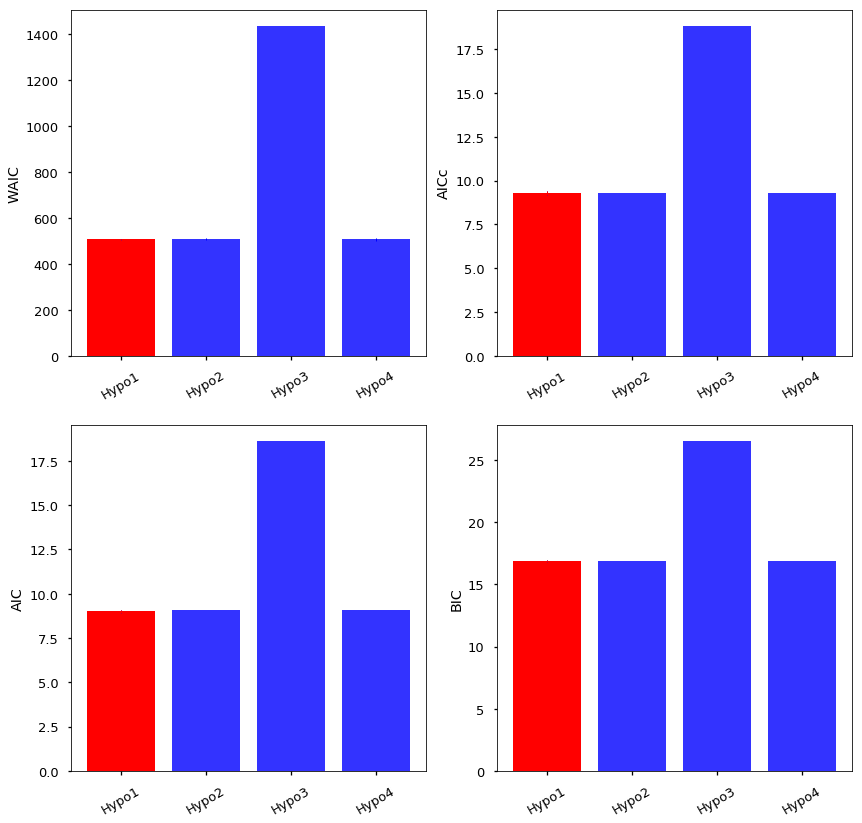

In [75]:
figure(figsize=(14, 14))

subplot(221)
y = waic
y_err = waic_err
bestmodel_barplot(y, y_err)
ylabel("WAIC")

subplot(222)
y = aicc
y_err = aicc_err
bestmodel_barplot(y, y_err)
ylabel("AICc")

subplot(223)
y = aic
y_err = aic_err
bestmodel_barplot(y, y_err)
ylabel("AIC")

subplot(224)
y = bic
y_err = bic_err
bestmodel_barplot(y, y_err)
ylabel("BIC")

show()

In [76]:
PSISs=[pystan.read_rdump(psis_file) for psis_file in all_PsisFiles]
PSISs=asarray(PSISs)

In [77]:
PSISs_dict = {}
for i in range(len(all_PsisFiles)):
    model = 'model' + str(i)
    PSISs_dict[model] = pystan.read_rdump(all_PsisFiles[i])

In [78]:
Loo=[]
Loo_err=[]
for i in range(len(all_PsisFiles)):
    Loo.append(PSISs[i]['loo'].mean())
    Loo_err.append(PSISs[i]['loo'].std())

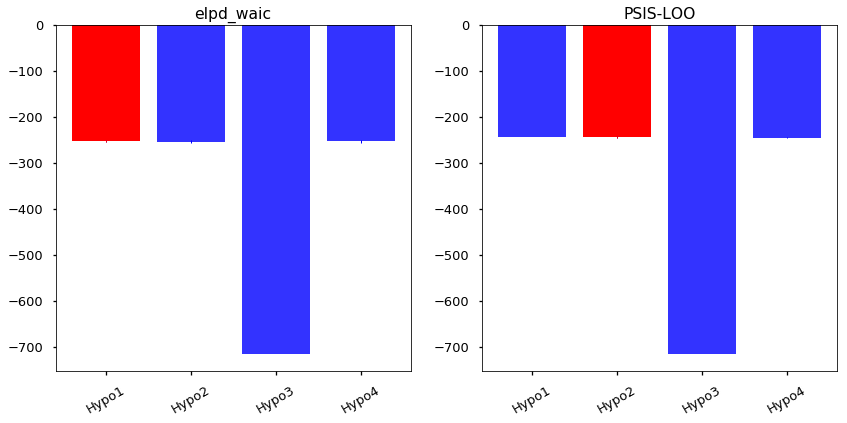

In [79]:
error_kw= dict(ecolor='b', capsize=6, elinewidth=1)
error_kw_red=dict(ecolor='r', capsize=6, elinewidth=1)

figure(figsize=(14, 14))

subplot(221)
y = elpd_waic
y_err = elpd_waic_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))],rotation=30);
title("elpd_waic")

subplot(222)
y = Loo
y_err = Loo_err
bar(range(len(y)), y, yerr=y_err, color='b', alpha=0.8, error_kw=error_kw)
bar(argmax(y), y[argmax(y)], yerr=y_err[argmax(y)], color='r',  error_kw=error_kw_red)
xticks(r_[:len(Models)], [Models[i] for i in range(0,len(Models))], rotation=30);
title("PSIS-LOO")
show()

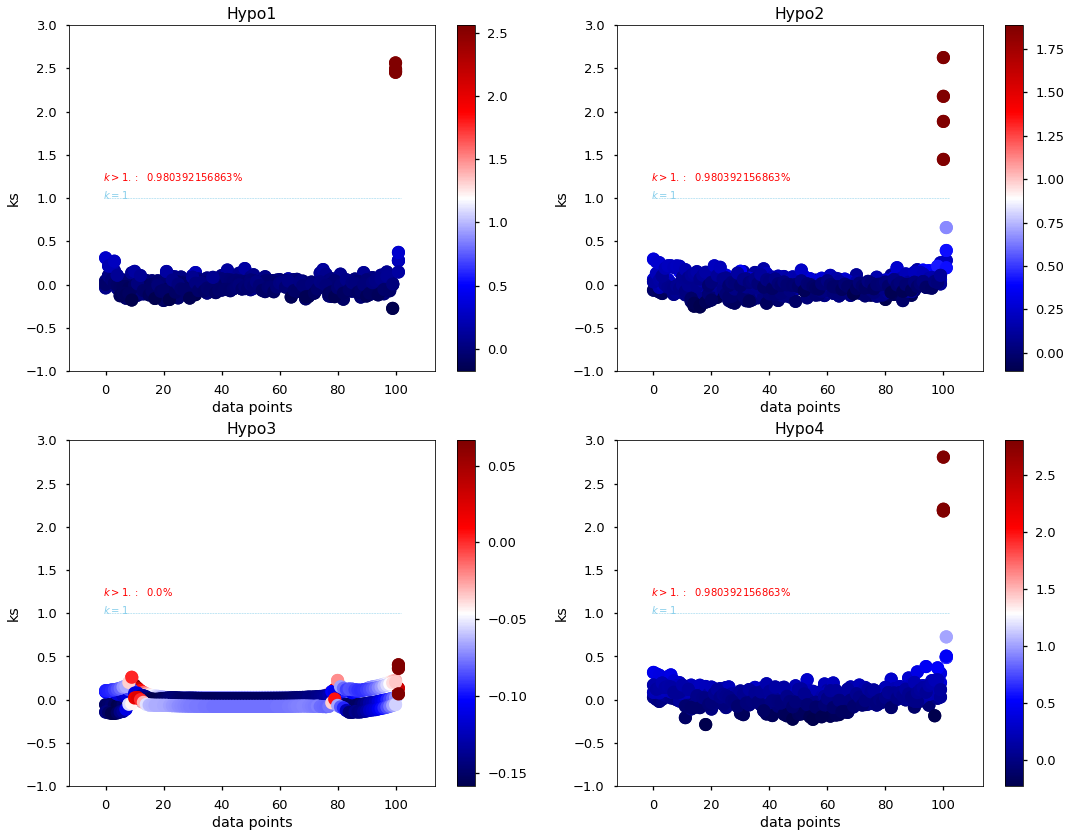

In [80]:
figure(figsize=(18, 14))

for i in range(len(all_PsisFiles)):
     subplot(len(all_PsisFiles)//2, 2, i + 1)  
     y=PSISs[i]['ks']
     k_=k_count(y,1.)
     for j in range(len(Chains)):
            yj=y[j,:]
            plot = plt.scatter(r_[:yj.shape[0]] , yj, c = yj, cmap = 'seismic', lw=4)
            yallj=yj.flatten()
            plotallj = plt.scatter(r_[:yallj.shape[0]] , yallj, c = yallj, cmap = 'seismic', lw=4)
     plt.colorbar(plotallj)       
     plt.hlines(y=1., xmin=0., xmax=yj.shape[0], linewidth=.5, color = 'skyblue', linestyle='--' )
     text(-1,0.99, "$k=1.$", size=10, color = 'skyblue')
     text(-1, 1.2,  r'$k > 1.:\ \ $'+str(k_)+r'$\%$' , size=10, color = 'red')
     ylim([-1,3.])
     plt.margins(0.11, 0.1)
     #norm_colorbar(y.flatten())
     ylabel('ks')
     xlabel('data points')
     title(Models[i])

show() 